# Linear Regression with JAX
Source: https://danielrothenberg.com/blog/2020/Sep/jax-first-steps-pt1/

In [11]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from jax import random

def make_key():
    """ Helper function to generate a key for jax's parallel PRNG 
    using standard numpy random functions. 

    """
    seed = np.random.randint(2**16 - 1)
    return random.PRNGKey(seed)

n = 100
rands = random.uniform(make_key(), shape=(n, ), minval=-1, maxval=1)

In [3]:
# We have to use functions to update an array unlike numpy as JAX does not mutate arrays in-place

x = jnp.ones((n, 2))
print(x)
x = x.at[:, 0].set(rands)
print(x)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[ 0.56719136  1.        ]
 [ 0.90619564  1.        ]
 [ 0.8181107   1.        ]
 [-0.07588315  1. 

# Simple first model

$$
    y = X\beta + \epsilon
$$

where $\beta = [\beta_0, \beta_1]$ where $\beta_0$ is an offset bias and $\beta_1$ a relating x and y, and $\epsilon$ is an uncorrelated noise modeled as a normal distribution, $\mathcal{N}(0, 1)$.

In [4]:
# Fix our true slope and bias
slope, bias = 3.0, 2.0
beta_true = jnp.array((slope, bias))
eps = random.normal(make_key(), shape=(n,))

In [5]:
y = (x @ beta_true) + eps

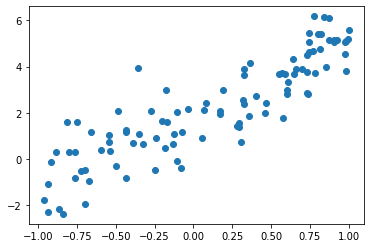

In [6]:
plt.scatter(x[:,0], y)

# Analytical Model Fitting


If the problem is simple enough, we can find a closed form analytical solution to the problem. We seek to find the $\beta$ that predicts the relationship between x and y. If we use $\mathcal{L}(\beta)=||\mathbf{X}\beta-\mathbf{Y}||$, the analytical solution is:

$$
    \frac{\partial \mathcal{L}(\beta)}{\partial \beta} = -2 \mathbf{Y}^T\mathbf{X}+2\beta^T\mathbf{X}^T\mathbf{X}
$$

And solving for 0 gives:

$$
\beta = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}
$$

In [7]:
beta_ols = jnp.linalg.inv(x.T @ x) @ (x.T @ y)
print(beta_ols)

[3.0753026 1.8672338]


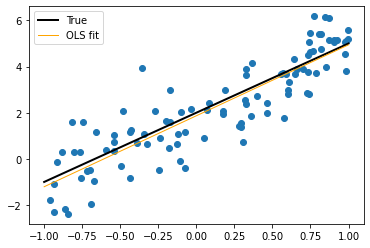

In [8]:
plt.scatter(x[:, 0], y)

xs = np.linspace(-1, 1)
xs = np.stack([xs, np.ones_like(xs)], axis=1)
ys_true = xs@beta_true
ys_fit = xs@beta_ols
plt.plot(xs[:, 0], ys_true, color='k', lw=2, label="True")
plt.plot(xs[:, 0], ys_fit, color='orange', lw=1, label='OLS fit')
plt.legend();

# Gradient Descent

Minimize the error metric, in this case MSE:
$$
    MSE = \frac{1}{n}\Sigma^n_{i=1}(\hat{y_i}-y_i)^2
$$

In [12]:
def mse(y_hat, y): return jnp.power(y_hat - y, 2).mean()

In [13]:
test = jnp.array([-1., 1.])
print(mse(x@test, y))

9.145107


Now we can use the power of JAX for automatic differentiation

In [14]:
from jax import grad

In [15]:
def predict(beta, x): return x @ beta
def loss_fn(beta, x, y=y): return mse(predict(beta, x), y)

In [16]:
grad_loss_fn = grad(loss_fn, argnums=0)

In [17]:
print(test, grad_loss_fn(test, x))

[-1.  1.] [-3.3981533 -2.7396417]


We will find the optimal value of $\beta$ by iteratively updating it with the old value subtracted by a learning rate times the derivative of the loss function w.r.t. $\beta$, i.e.:

$$
    \beta_{n+1} = \beta_{n} - \gamma \frac{\partial\mathcal{L}(\beta)}{\partial\beta}
$$

In [18]:
def gradient_descent(beta, lr=1e-1, x=x, y=y): return beta - lr * grad_loss_fn(beta, x, y=y)

In [19]:
beta_gd = jnp.array([-1., 1.])
lr = 5e-2

In [24]:
for epoch in range(200):
    if (epoch % 10) == 0: print(epoch, beta_gd)
    
    beta_new = gradient_descent(beta_gd)
    
    rel_err = np.sqrt(np.mean((beta_gd - beta_new)**2))
    
    if rel_err < 1e-3:
        print(f"converged -> relative error: {rel_err})")
        break
        
    beta_gd = beta_new

0 [0.17539409 1.7678423 ]
10 [1.766862  2.0548797]
20 [2.4689775 1.9785113]
30 [2.7926652 1.9215833]
40 [2.9433815 1.8928522]
50 [3.0137112 1.8792199]
60 [3.0465453 1.8728325]
converged -> relative error: 0.0009619885240681469)


In [25]:
beta_gd

DeviceArray([3.0570934, 1.8707792], dtype=float32)

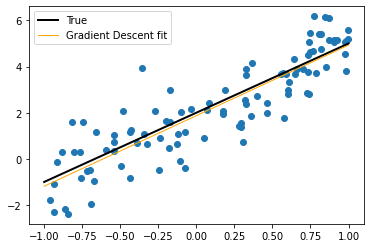

In [26]:
plt.scatter(x[:, 0], y)

xs = np.linspace(-1, 1)
xs = np.stack([xs, np.ones_like(xs)], axis=1)
ys_true = xs@beta_true
ys_fit = xs@beta_gd
plt.plot(xs[:, 0], ys_true, color='k', lw=2, label="True")
plt.plot(xs[:, 0], ys_fit, color='orange', lw=1, label='Gradient Descent fit')
plt.legend();